<a href="https://colab.research.google.com/github/sjsu-cs133-f25/team5-climatechange-trends/blob/main/02_visual_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Warming Dataset Visual Analytics

# Data Card


Dataset source & link, shape (rows/cols), units, time coverage:
*   Dataset source: Global Warming Dataset: 195 Countries (1900-2023)
*   Dataset link: https://www.kaggle.com/datasets/ankushpanday1/global-warming-dataset-195-countries-1900-2023
*   shape: 100,000 rows and 26 columns
*   units: numerical, categorical
*   time coverage: 1900-2023


Column dictionary (human-readable; short), key ID columns, target(s) if any:
*   shape: 100,000 rows and 26 columns

      * Country - the country identifier
      * Year - the year, from 1900-2023
      * Temperature_Anomoly - difference in temperature from baseline, in °C
      * CO2_Emissions - total CO2 emissions, in metric tons
      * Population - number of people in the country
      * Forest Area - area of forest cover, in % of land area
      * GDP - Gross Domestic Product, in USD
      * Renewable_Energy_Usage - total energy derived from renewable energy sources, in %
      * Methane_Emissions - total methane emissions, in metric tons CO2 equivalent
      * Sea_Level_Rise - change in sea level, in mm
      * Arctic_Ice_Extent - area covered by arctic ice, in million km²
      * Urbanization - population living in urban areas, in %
      * Deforestation_Rate - loss of forest area, in %
      * Extreme_Weather_Events - count of extreme events that occurred
      * Average_Rainfall - average precipitation, in mm
      * Solar_Energy_Potential - potential for solar energy, in kWh/m²
      * Waste_Management - score of the country's waste management practices, in %
      * Per_Capita_Emissions - total greenhouse gases emissions per capita, in tons / person
      * Industrial_Activity - industrial output or production, in %
      * Air_Pollution_Index - air quality index, from 0-300
      * Biodiversity_Index - measures the variety of species, in %
      * Ocean_Acidification - pH level of ocean
      * Fossil_Fuel_Usage - total energy consumption from fossil fuels, in %
      * Energy_Consumption_Per_Capita - energy usage per person
      * Policy_Score - the country's climate policy performance score, from 0-100
      * Average_Temperature - average temperature, in °C



Missingness snapshot: which columns have NaNs and rough %:
*   NaNs: zero columns


Known quirks (e.g., mixed types, inconsistent labels):
*    the meaning of the values for some of the columns, such as the policy score, and the units for some are ambiguous
*    The countries column did not specify the names of the actual countries and instead labeled countries numerically


# Load

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import kagglehub

In [2]:
# download dataset
path = kagglehub.dataset_download("ankushpanday1/global-warming-dataset-195-countries-1900-2023")

100%|██████████| 20.5M/20.5M [00:00<00:00, 104MB/s]

Extracting files...


In [3]:
# read csv file
df = pd.read_csv(path + "/global_warming_dataset.csv")

# Prep

In [4]:
# 1 Remove spaces
df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

# 2 Convert to numeric
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
df["Country"] = df["Country"].astype("category")

num_cols = df.columns.difference(["Country", "Year"])
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# 3 Handle missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 4 Group by Country, Year
df = df.groupby(["Country", "Year"], as_index=False, observed=False).mean(numeric_only=True)

print("Missing Values:", df.isna().any().sum())
print("Duplicates:", df.duplicated().sum())

Missing Values: 24
Duplicates: 0


# Transforms

In [5]:
# Make categories ordered for nicer sorting/plots.
gdp_order = pd.CategoricalDtype(
    categories=["Low Income", "Lower-Middle Income", "Upper-Middle Income", "High Income"],
    ordered=True
)

cat_order = pd.CategoricalDtype(
    categories=["Low", "Medium", "High"],
    ordered=True
)

In [19]:
# Temperature increase flag
df["Temp_Increased"] = df["Temperature_Anomaly"] > 0

# Air Quality Category
def pollution_category(x):
    if x > 200:     return "Very Unhealthy"
    elif x > 150:   return "Unhealthy"
    elif x > 100:   return "Unhealthy (Sensitive)"
    elif x > 50:    return "Moderate"
    else:           return "Good"
df["Air_Quality_Category"] = df["Air_Pollution_Index"].map(pollution_category)

# GDP per capita and Income group
df["GDP_per_capita"] = df["GDP"] / df["Population"]

def gdp_category(x):
    if x >= 13846:  return "High Income"
    elif x >= 4466: return "Upper-Middle Income"
    elif x >= 1136: return "Lower-Middle Income"
    else:           return "Low Income"
df["GDP_Income_Group"] = df["GDP_per_capita"].map(gdp_category).astype(gdp_order)

# CO2 per capita
df["CO2_per_capita"] = df["CO2_Emissions"] / df["Population"]

# Renewable Energy Usage Groups
def renewable_group(x):
    if x >= 50:     return "High"
    elif x >= 20:   return "Medium"
    else:           return "Low"
df["Renewable_Group"] = df["Renewable_Energy_Usage"].apply(renewable_group).astype("category")

# Industrial Activity Groups
def industrial_activity_group(x):
    if x >= 80:     return "High"
    elif x < 80 & x >= 40:   return "Medium"
    else:           return "Low"
df['Industrial_Activity_Group'] = df.Industrial_Activity.map(renewable_group).astype(cat_order)

# Decades
def get_decade(year):
  decade = year // 10
  decade_str = str(decade * 10) + "'s"
  return decade_str

df['Decade'] = df.Year.map(get_decade)

# Visuals

### 1. Categorical Distribution Comparison Plots

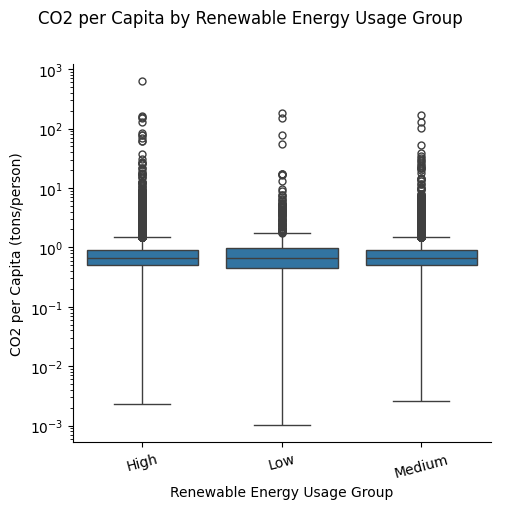

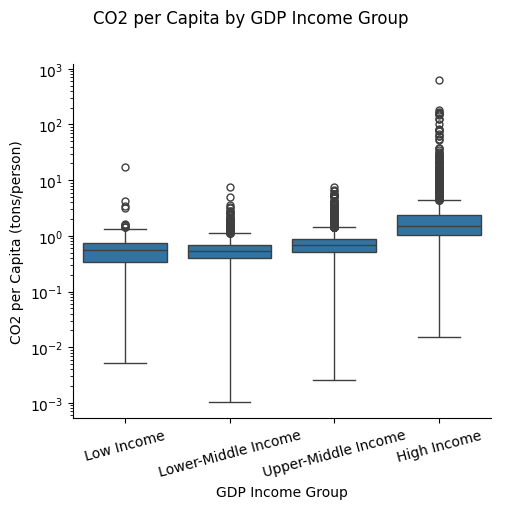

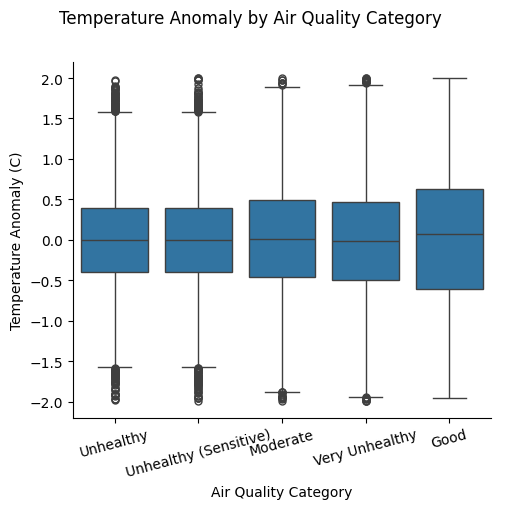

In [7]:
# CO2 per Capita by Renewable Energy Usage Group
g = sns.catplot(
    data=df,
    x="Renewable_Group",
    y="CO2_per_capita",
    kind="box",
)
g.set(yscale="log")
g.set_axis_labels("Renewable Energy Usage Group", "CO2 per Capita (tons/person)")
g.figure.suptitle("CO2 per Capita by Renewable Energy Usage Group", y=1.01)
plt.xticks(rotation=15)
g.figure.tight_layout()

# CO2 per Capita by GDP Income Group
g = sns.catplot(
    data=df,
    x="GDP_Income_Group",
    y="CO2_per_capita",
    kind="box",
)
g.set(yscale="log")
g.set_axis_labels("GDP Income Group", "CO2 per Capita (tons/person)")
g.figure.suptitle("CO2 per Capita by GDP Income Group", y=1.01)
plt.xticks(rotation=15)
g.figure.tight_layout()

# Temperature Anomaly by Air Quality Category
g = sns.catplot(
    data=df,
    x="Air_Quality_Category",
    y="Temperature_Anomaly",
    kind="box",
)
g.set_axis_labels("Air Quality Category", "Temperature Anomaly (C)")
g.figure.suptitle("Temperature Anomaly by Air Quality Category", y=1.01)
plt.xticks(rotation=15)
g.figure.tight_layout();


### 2. Regression Plots

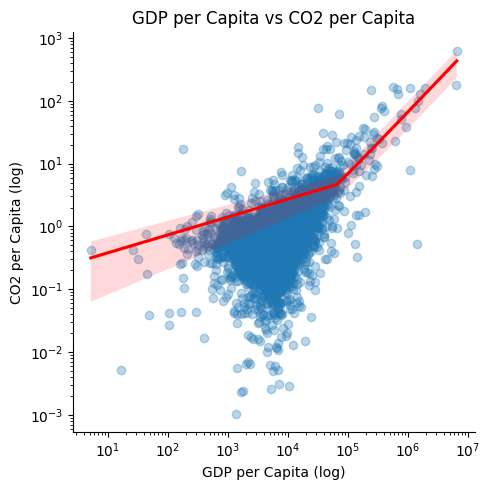

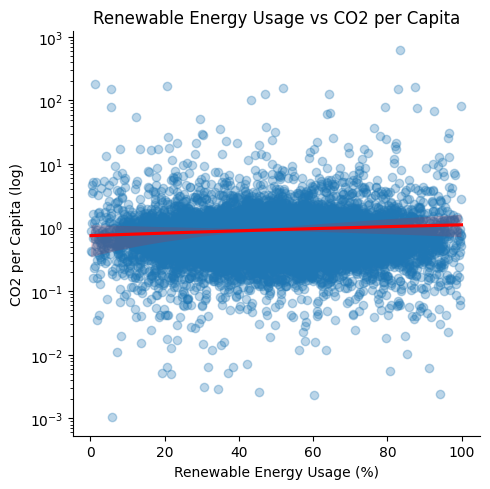

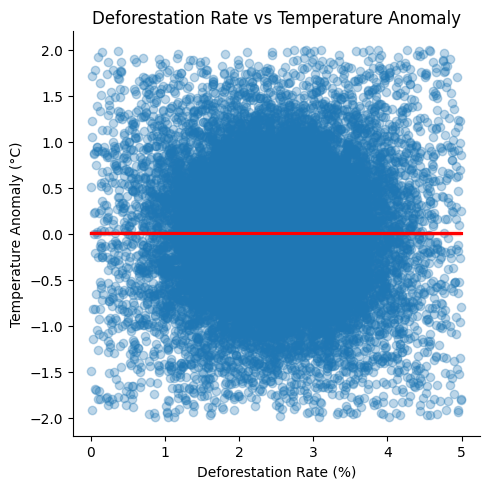

In [8]:
# GDP per Capita vs CO2 per Capita
sns.lmplot(
    data=df,
    x="GDP_per_capita",
    y="CO2_per_capita",
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"},
)
plt.xscale("log")
plt.yscale("log")
plt.title("GDP per Capita vs CO2 per Capita")
plt.xlabel("GDP per Capita (log)")
plt.ylabel("CO2 per Capita (log)")
plt.tight_layout()

# Renewable Energy Usage vs CO2 per Capita
sns.lmplot(
    data=df,
    x="Renewable_Energy_Usage",
    y="CO2_per_capita",
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"},
)
plt.yscale("log")
plt.title("Renewable Energy Usage vs CO2 per Capita")
plt.xlabel("Renewable Energy Usage (%)")
plt.ylabel("CO2 per Capita (log)")
plt.tight_layout()

# Deforestation Rate vs Temperature Anomaly
sns.lmplot(
    data=df,
    x="Deforestation_Rate",
    y="Temperature_Anomaly",
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"},
)
plt.title("Deforestation Rate vs Temperature Anomaly")
plt.xlabel("Deforestation Rate (%)")
plt.ylabel("Temperature Anomaly (°C)")
plt.tight_layout();


### 3. Small Multiples Plots

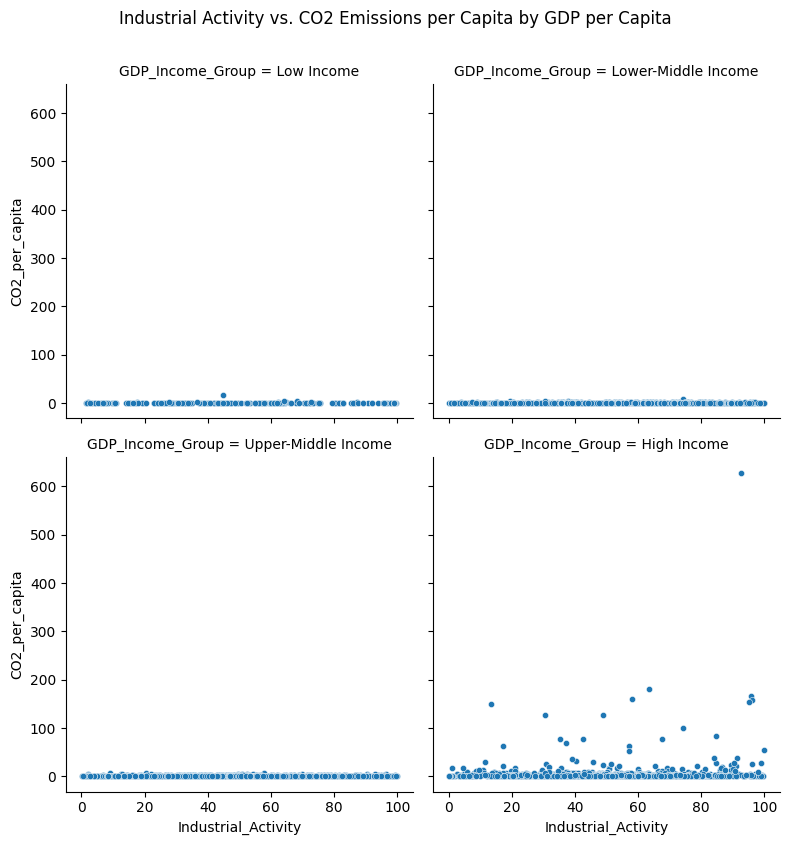

In [9]:
# small multiples plot depicting Industrial Activity vs. CO2 Emissions per Capita by GDP per Capita
p=sns.relplot(
    data=df,
    x="Industrial_Activity",
    y='CO2_per_capita',
    col="GDP_Income_Group",
    col_wrap=2,
    height=4,
    s=20
)
p.fig.suptitle("Industrial Activity vs. CO2 Emissions per Capita by GDP per Capita", y=1.05);

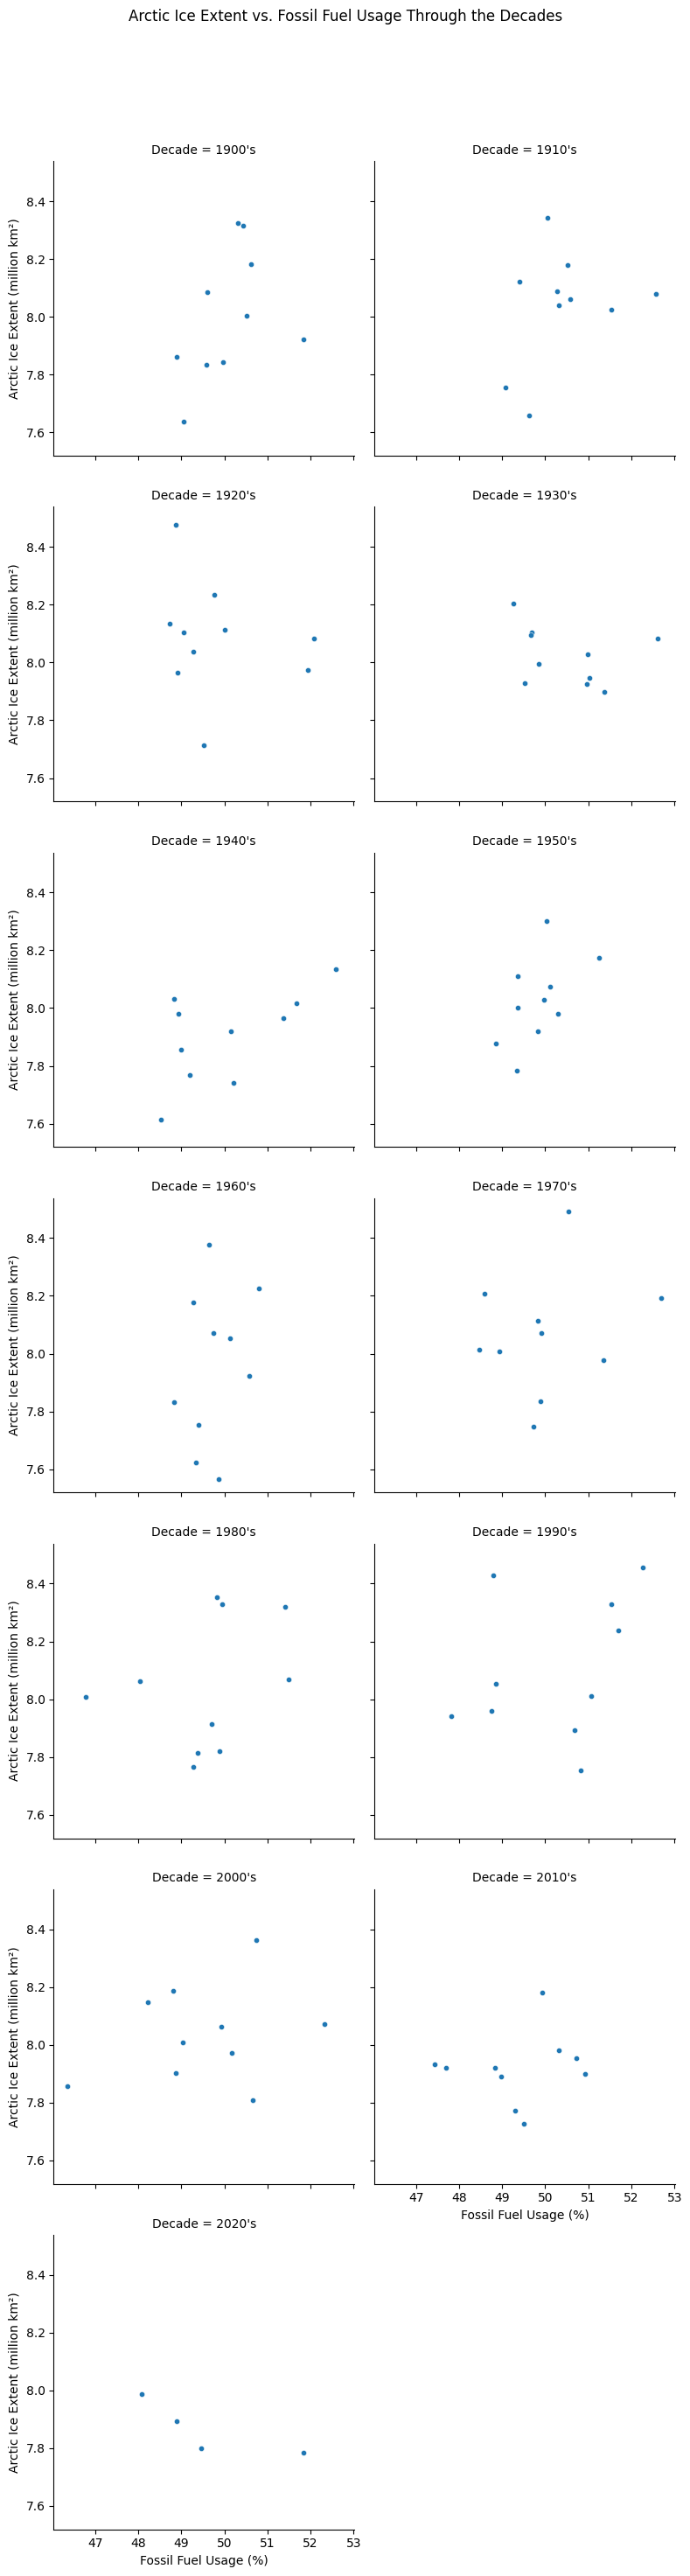

In [11]:
# small multiples plot depicting Arctic Ice Extent vs. Fossil Fuel Usage Through the Decades
p=sns.relplot(
    data=df,
    x=df.groupby('Year').Fossil_Fuel_Usage.median(),
    y=df.groupby('Year').Arctic_Ice_Extent.median(),
    col="Decade",
    col_wrap=2,
    height=4,
    s=20
)
p.set_ylabels("Arctic Ice Extent (million km²)", clear_inner=False)
p.set_xlabels("Fossil Fuel Usage (%)", clear_inner=False)
p.fig.suptitle("Arctic Ice Extent vs. Fossil Fuel Usage Through the Decades", y=1.05);

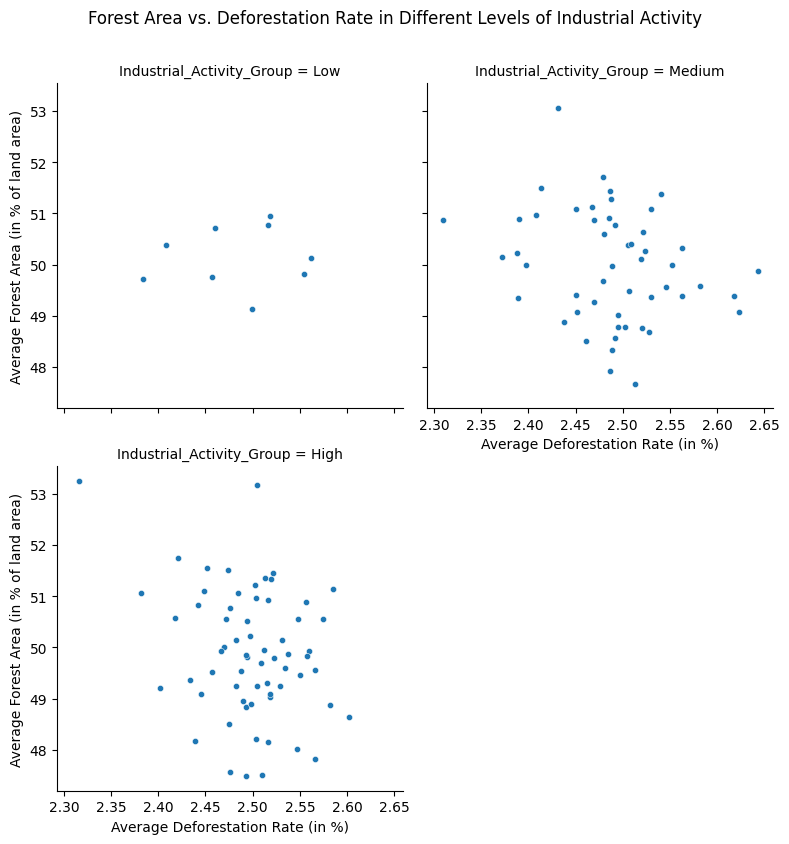

In [20]:
# small multiples plot depicting Industrial Activity vs. CO2 Emissions per Capita by GDP per Capita
p=sns.relplot(
    data=df,
    x=df.groupby('Year').Deforestation_Rate.mean(),
    y=df.groupby('Year').Forest_Area.mean(),
    col="Industrial_Activity_Group",
    col_wrap=2,
    height=4,
    s=20
)
p.set_ylabels("Average Forest Area (in % of land area)", clear_inner=False)
p.set_xlabels("Average Deforestation Rate (in %)", clear_inner=False)
p.fig.suptitle("Forest Area vs. Deforestation Rate in Different Levels of Industrial Activity", y=1.05);